# Benchmark PyRCN

This notebook accompanies the publication "PyRCN: A Toolbox for Exploration and Application of Reservoir Computing Networks" and serves as a benchmark test for PyRCN and other libraries.

Technical analysis -> Chart Analyse

In [1]:
import pandas as pd
import itertools
from collections import OrderedDict

from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from joblib import dump, load

from pyrcn.extreme_learning_machine import ELMRegressor
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.model_selection import SequentialSearchCV
from skelm import ELMRegressor as SkELMRegressor
import seaborn as sns
import matplotlib.pyplot as plt

from src.preprocessing import ts2super, compute_average_volatility
from src.model_selection import PredefinedTrainValidationTestSplit
from src.adapter import PyESN


%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('png', 'pdf')
sns.set_theme(context="paper", style="whitegrid", font="serif", font_scale=.8)

C:\Users\Steiner\AppData\Local\Temp\ipykernel_4036\1679389469.py:29: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


## Prepare all datasets

We load the datasets as pandas dataframes

In [2]:
datasets = OrderedDict({"CAT": 0, "EBAY": 1, "MSFT": 2})
data = [None] * len(datasets)

for dataset, k in datasets.items():
    data[k] = pd.read_csv(f"./data/{dataset}.csv")["t0"].to_frame()

Next, we create feature extraction pipelines.

In [3]:
day_volatility_transformer = FunctionTransformer(
    func=compute_average_volatility, kw_args={"window_length": 1})
week_volatility_transformer = FunctionTransformer(
    func=compute_average_volatility, kw_args={"window_length": 5})
month_volatility_transformer = FunctionTransformer(
    func=compute_average_volatility, kw_args={"window_length": 22})
har_features = FeatureUnion(
    transformer_list=[("day", day_volatility_transformer),
                      ("week", week_volatility_transformer),
                      ("month", month_volatility_transformer)])
har_pipeline = Pipeline(
    steps=[("har_features", har_features),
           ("scaler", MinMaxScaler()),
           ("lstsq", TransformedTargetRegressor(transformer=MinMaxScaler()))])

We define a forecasting horizon for which we want to optimize and analyze models

In [4]:
H=1  # pre-trained models available for 1, 5, 21

# ts2super simply returns a dataframe containing the original and shifted by H time series.
df = pd.concat([ts2super(d, 0, H) for d in data])
X = df.iloc[:, 0].values.reshape(-1, 1)
y = df.iloc[:, -1].values.reshape(-1, 1)

In [5]:
df_input = df.iloc[:, 0].to_frame()
df_input["t5"] = df_input.t0.rolling(window=5, min_periods=1).mean()
df_input["t22"] = df_input.t0.rolling(window=22, min_periods=1).mean()
df_input

,t0,t5,t22
0,0.000223,0.000223,0.000223
1,0.000121,0.000172,0.000172
2,0.000124,0.000156,0.000156
3,0.000268,0.000184,0.000184
4,0.000832,0.000314,0.000314
...,...,...,...
2739,0.000116,0.000077,0.000063
2740,0.000152,0.000092,0.000065
2741,0.000095,0.000096,0.000068
2742,0.000194,0.000125,0.000075


In [6]:
df_input_extended = pd.concat([pd.DataFrame(data={"t0": [0], "t5": [0], "t22": [0]}), df_input], ignore_index=False).reset_index(drop=True)
df_input_extended["t0"] = df_input_extended["t0"].shift(periods=-1)
df_input_extended = df_input_extended.dropna()

In [7]:
df_input_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8232 entries, 0 to 8231
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t0      8232 non-null   float64
 1   t5      8232 non-null   float64
 2   t22     8232 non-null   float64
dtypes: float64(3)
memory usage: 257.2 KB


Provide a custom train test split for this task, and all scores that we aim to evaluate.

In [8]:
test_fold = [[k] * len(ts2super(d, 0, H)) for k, d in enumerate(data)]
test_fold = list(itertools.chain.from_iterable(test_fold))

ps = PredefinedTrainValidationTestSplit(test_fold=test_fold, validation=True)
ps_test = PredefinedTrainValidationTestSplit(test_fold=test_fold, validation=False)

scoring = {"MSE": "neg_mean_squared_error", "RMSE": "neg_root_mean_squared_error", "R2": "r2"}

## HAR

The HAR (Heterogeneous AutoRegressive) features are, as the name says, autoregressive features. Here, temporal context is considered by smoothing a time series with moving averages of the last week (5 days) and month (22 days). The smoothed variants are finally added to the original time series. Thus, HAR has three features.

TODO: HAR-Feature extraction outside of the pipeline

In [9]:
har_pipeline = Pipeline(
    steps=[# ("har_features", har_features),
           ("scaler", MinMaxScaler()),
           ("lstsq", TransformedTargetRegressor(transformer=MinMaxScaler()))])

In [10]:
try:
    search = load(f'./results/har_grid_h{H}_modified.joblib')
except FileNotFoundError:
    search = GridSearchCV(estimator=har_pipeline, param_grid={}, cv=ps_test,
                          scoring=scoring, refit="R2", return_train_score=True, verbose=10).fit(df_input_extended, y)
    dump(search, f'./results/har_grid_h{H}_modified.joblib')

In [11]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search.cv_results_['mean_train_R2']}\t{search.cv_results_['mean_test_R2']}\t"
      f"{search.cv_results_['mean_train_MSE']}\t{search.cv_results_['mean_test_MSE']}\t"
      f"{search.cv_results_['mean_fit_time']*1e3}\t{search.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.65237827]	[0.63512707]	[-5.69993759e-08]	[-5.72980439e-08]	[5.01338641]	[2.00780233]


## PyRCN ESN

Next, we optimize ESNs from PyRCN using only the original time series as features.

In [12]:
try:
    search = load(f'./results/pyrcn_seq_esn_h{H}.joblib')
except FileNotFoundError:
    initial_esn_params = {
        'hidden_layer_size': 50, 'k_in': 1, 'input_scaling': 0.4, 'input_activation': 'identity',
        'bias_scaling': 0.0, 'spectral_radius': 0.0, 'leakage': 1.0, 'k_rec': 10,
        'reservoir_activation': 'tanh', 'bidirectional': False, 'alpha': 1e-5, 'random_state': 42}
    esn_pipeline = Pipeline(steps=[("scaler", MinMaxScaler()),
                                   ("esn", TransformedTargetRegressor(
                                       regressor=ESNRegressor(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'esn__regressor__input_scaling': uniform(loc=1e-2, scale=1),
                    'esn__regressor__spectral_radius': uniform(loc=0, scale=2)}
    step2_params = {'esn__regressor__leakage': uniform(1e-5, 1e0)}
    step3_params = {'esn__regressor__bias_scaling': uniform(loc=0, scale=3)}
    step4_params = {'esn__regressor__hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'esn__regressor__alpha': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step4 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
        ('step3', RandomizedSearchCV, step3_params, kwargs_step3),
        ('step4', RandomizedSearchCV, step4_params, kwargs_step4)]
    search = SequentialSearchCV(esn_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/pyrcn_seq_esn_h{H}.joblib')
print(search.all_best_params_)

{'step1': {'esn__regressor__input_scaling': 0.1370605126518848, 'esn__regressor__spectral_radius': 1.0444865201096087}, 'step2': {'esn__regressor__leakage': 0.9699198521619943}, 'step3': {'esn__regressor__bias_scaling': 0.17425083650459838}, 'step4': {'esn__regressor__alpha': 0.0039054412752107916, 'esn__regressor__hidden_layer_size': 50}}


We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [13]:
try:
    search_test = load(f'./results/pyrcn_seq_esn_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/pyrcn_seq_esn_h{H}_test.joblib')

In [14]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.68053009]	[0.64391385]	[-5.23117243e-08]	[-5.62020917e-08]	[386.06230418]	[157.21750259]


Next, we optimize ESNs from PyRCN using HAR as features.

In [15]:
try:
    search = load(f'./results/pyrcn_har_seq_esn_h{H}.joblib')
except FileNotFoundError:
    initial_esn_params = {
        'hidden_layer_size': 50, 'k_in': 1, 'input_scaling': 0.4, 'input_activation': 'identity',
        'bias_scaling': 0.0, 'spectral_radius': 0.0, 'leakage': 1.0, 'k_rec': 10,
        'reservoir_activation': 'tanh', 'bidirectional': False, 'alpha': 1e-5, 'random_state': 42}
    esn_pipeline = Pipeline(steps=[("har_features", har_features),
                                   ("scaler", MinMaxScaler()),
                                   ("esn", TransformedTargetRegressor(
                                       regressor=ESNRegressor(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'esn__regressor__input_scaling': uniform(loc=1e-2, scale=1),
                    'esn__regressor__spectral_radius': uniform(loc=0, scale=2)}
    step2_params = {'esn__regressor__leakage': uniform(1e-5, 1e0)}
    step3_params = {'esn__regressor__bias_scaling': uniform(loc=0, scale=3)}
    step4_params = {'esn__regressor__hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'esn__regressor__alpha': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step4 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
        ('step3', RandomizedSearchCV, step3_params, kwargs_step3),
        ('step4', RandomizedSearchCV, step4_params, kwargs_step4)]
    search = SequentialSearchCV(esn_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/pyrcn_har_seq_esn_h{H}.joblib')
print(search.all_best_params_)

{'step1': {'esn__regressor__input_scaling': 0.0616817211686077, 'esn__regressor__spectral_radius': 1.062709263136296}, 'step2': {'esn__regressor__leakage': 0.9699198521619943}, 'step3': {'esn__regressor__bias_scaling': 0.6370173320348285}, 'step4': {'esn__regressor__alpha': 0.0039054412752107916, 'esn__regressor__hidden_layer_size': 50}}


We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [16]:
try:
    search_test = load(f'./results/pyrcn_har_seq_esn_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/pyrcn_har_seq_esn_h{H}_test.joblib')

In [17]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.66340464]	[0.63908494]	[-5.5212558e-08]	[-5.67360705e-08]	[380.05018234]	[165.33001264]


## PyRCN ELM

Next, we optimize ELMs from PyRCN using only the original time series as features.

In [18]:
try:
    search = load(f'./results/pyrcn_seq_elm_h{H}.joblib')
except FileNotFoundError:
    initial_elm_params = {
        'hidden_layer_size': 50, 'k_in': 1, 'input_scaling': 0.4, 'input_activation': 'tanh',
        'bias_scaling': 0.0, 'alpha': 1e-5, 'random_state': 42}
    elm_pipeline = Pipeline(steps=[("scaler", MinMaxScaler()),
                                   ("'random_state': 42", TransformedTargetRegressor(
                                       regressor=ELMRegressor(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'elm__regressor__input_scaling': uniform(loc=1e-2, scale=1)}
    step2_params = {'esn__regressor__bias_scaling': uniform(loc=0, scale=3)}
    step3_params = {'elm__regressor__hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'elm__regressor__alpha': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step3 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
        ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]
    search = SequentialSearchCV(elm_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/pyrcn_seq_elm_h{H}.joblib')
print(search.all_best_params_)

{'step1': {'elm__regressor__input_scaling': 0.19485445552552705}, 'step2': {'elm__regressor__bias_scaling': 0.06175348288740734}, 'step3': {'elm__regressor__alpha': 0.0039054412752107916, 'elm__regressor__hidden_layer_size': 50}}


We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [19]:
try:
    search_test = load(f'./results/pyrcn_seq_elm_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/pyrcn_seq_elm_h{H}_test.joblib')

In [20]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.60909129]	[0.57842047]	[-6.40947295e-08]	[-6.61803246e-08]	[19.38573519]	[7.68685341]


Next, we optimize ELMs from PyRCN using HAR as features.

In [21]:
try:
    search = load(f'./results/pyrcn_har_seq_elm_h{H}.joblib')
except FileNotFoundError:
    initial_elm_params = {
        'hidden_layer_size': 50, 'k_in': 1, 'input_scaling': 0.4, 'input_activation': 'tanh',
        'bias_scaling': 0.0, 'alpha': 1e-5, 'random_state': 42}
    elm_pipeline = Pipeline(steps=[("har_features", har_features),
                                   ("scaler", MinMaxScaler()),
                                   ("'random_state': 42", TransformedTargetRegressor(
                                       regressor=ELMRegressor(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'elm__regressor__input_scaling': uniform(loc=1e-2, scale=1)}
    step2_params = {'elm__regressor__bias_scaling': uniform(loc=0, scale=3)}
    step3_params = {'elm__regressor__hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'elm__regressor__alpha': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step3 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
        ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]
    search = SequentialSearchCV(elm_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/pyrcn_har_seq_elm_h{H}.joblib')
print(search.all_best_params_)

{'step1': {'elm__regressor__input_scaling': 0.10767211400638386}, 'step2': {'elm__regressor__bias_scaling': 0.06175348288740734}, 'step3': {'elm__regressor__alpha': 0.0039054412752107916, 'elm__regressor__hidden_layer_size': 50}}


We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [22]:
try:
    search_test = load(f'./results/pyrcn_har_seq_elm_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/pyrcn_har_seq_elm_h{H}_test.joblib')

In [23]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.65465176]	[0.63638384]	[-5.66300844e-08]	[-5.72052643e-08]	[34.43511327]	[17.04589526]


## HP-ELM

Next, we optimize ELMs from HP-ELM using only the original time series as features.

In [24]:
try:
    search = load(f'./results/skelm_seq_elm_h{H}.joblib')
except FileNotFoundError:
    initial_elm_params = {
        'hidden_layer_size': 50, 'k_in': 1, 'input_scaling': 0.4, 'input_activation': 'tanh',
        'bias_scaling': 0.0, 'alpha': 1e-5, 'random_state': 42}
    elm_pipeline = Pipeline(steps=[("scaler", MinMaxScaler()),
                                   ("'random_state': 42", TransformedTargetRegressor(
                                       regressor=ELMRegressor(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'elm__regressor__input_scaling': uniform(loc=1e-2, scale=1)}
    step2_params = {'elm__regressor__bias_scaling': uniform(loc=0, scale=3)}
    step3_params = {'elm__regressor__hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'elm__regressor__alpha': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step3 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
        ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]
    search = SequentialSearchCV(elm_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/skelm_seq_elm_h{H}.joblib')
print(search.all_best_params_)

{'step1': {'elm__regressor__alpha': 1.3992515562068698e-05, 'elm__regressor__n_neurons': 50}}


We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [25]:
try:
    search_test = load(f'./results/skelm_seq_elm_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/skelm_seq_elm_h{H}_test.joblib')

In [26]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.59809498]	[0.57096063]	[-6.58363427e-08]	[-6.69125931e-08]	[13.70278994]	[5.85301717]


Next, we optimize ELMs from HP-ELM using HAR as features.

In [27]:
try:
    search = load(f'./results/skelm_har_seq_elm_h{H}.joblib')
except FileNotFoundError:
    initial_elm_params = {
        'hidden_layer_size': 50, 'k_in': 1, 'input_scaling': 0.4, 'input_activation': 'tanh',
        'bias_scaling': 0.0, 'alpha': 1e-5, 'random_state': 42}
    elm_pipeline = Pipeline(steps=[("har_features", har_features),
                                   ("scaler", MinMaxScaler()),
                                   ("'random_state': 42", TransformedTargetRegressor(
                                       regressor=ELMRegressor(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'elm__regressor__input_scaling': uniform(loc=1e-2, scale=1)}
    step2_params = {'elm__regressor__bias_scaling': uniform(loc=0, scale=3)}
    step3_params = {'elm__regressor__hidden_layer_size': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'elm__regressor__alpha': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step3 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
        ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]
    search = SequentialSearchCV(esn_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/skelm_har_seq_elm_h{H}.joblib')
print(search.all_best_params_)

{'step1': {'elm__regressor__alpha': 0.0008961860696827896, 'elm__regressor__n_neurons': 400}}


We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [28]:
try:
    search_test = load(f'./results/pyrcn_har_seq_elm_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/pyrcn_har_seq_elm_h{H}_test.joblib')

In [29]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.65465176]	[0.63638384]	[-5.66300844e-08]	[-5.72052643e-08]	[34.43511327]	[17.04589526]


## PyESN ESN

Next, we optimize ESNs from PyESN using only the original time series as features.

In [30]:
try:
    search = load(f'./results/pyesn_seq_esn_h{H}.joblib')
except FileNotFoundError:
    initial_esn_params = {
        'n_inputs': 1, 'n_outputs': 1, 'n_reservoir': 50, 'spectral_radius': 0.0, 'sparsity': 0.5,
        'noise': 1e-3, 'input_shift': 0, 'input_scaling': 0.4, 'teacher_forcing': True,
        'teacher_scaling': 1.,'teacher_shift': 0, 'random_state': 42}
    esn_pipeline = Pipeline(steps=[("scaler", MinMaxScaler()),
                                   ("esn", TransformedTargetRegressor(
                                       regressor=PyESN(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'esn__regressor__input_scaling': uniform(loc=1e-2, scale=1),
                    'esn__regressor__spectral_radius': uniform(loc=0, scale=2)}
    step2_params = {'esn__regressor__n_reservoir': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'esn__regressor__noise': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2)]
    search = SequentialSearchCV(esn_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/pyesn_seq_esn_h{H}.joblib')
print(search.all_best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits



KeyboardInterrupt



We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [31]:
try:
    search_test = load(f'./results/pyesn_seq_esn_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/pyesn_seq_esn_h{H}_test.joblib')

In [32]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.64661273]	[0.61928317]	[-5.81438193e-08]	[-5.91675238e-08]	[105.38490613]	[51.34455363]


Next, we optimize ESNs from PyESN using HAR as features.

In [33]:
try:
    search = load(f'./results/pyesn_har_seq_esn_h{H}.joblib')
except FileNotFoundError:
    initial_esn_params = {
        'n_inputs': 1, 'n_outputs': 1, 'n_reservoir': 50, 'spectral_radius': 0.0, 'sparsity': 0.5,
        'noise': 1e-3, 'input_shift': 0, 'input_scaling': 0.4, 'teacher_forcing': True,
        'teacher_scaling': 1.,'teacher_shift': 0, 'random_state': 42}
    esn_pipeline = Pipeline(steps=[("har_features", har_features),
                                   ("scaler", MinMaxScaler()),
                                   ("esn", TransformedTargetRegressor(
                                       regressor=PyESN(**initial_esn_params),
                                       transformer=MinMaxScaler()))
                                  ])
    # Run model selection
    step1_params = {'esn__regressor__input_scaling': uniform(loc=1e-2, scale=1),
                    'esn__regressor__spectral_radius': uniform(loc=0, scale=2)}
    step2_params = {'esn__regressor__n_reservoir': [50, 100, 200, 400, 800, 1600, 3200, 6400],
                    'esn__regressor__noise': loguniform(1e-5, 1e1)}
    
    kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}
    kwargs_step2 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': scoring,
                    "refit": "R2", "cv": ps, "return_train_score": True}

    searches = [
        ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
        ('step2', RandomizedSearchCV, step2_params, kwargs_step2)]
    search = SequentialSearchCV(esn_pipeline, searches=searches).fit(X, y)
    dump(search, f'./results/pyesn_har_seq_esn_h{H}.joblib')
print(search.all_best_params_)

{'step1': {'esn__regressor__input_scaling': 0.7119668772577034, 'esn__regressor__spectral_radius': 1.591585338872202}, 'step2': {'esn__regressor__n_reservoir': 50, 'esn__regressor__noise': 1.246802066209201e-05}}


We do an additional GridSearchCV without parameters, because the object returns a mass of useful information.

If we do it without parameters, simply the estimator will be fit on the train test splits defined in our cv.

In [6]:
try:
    search_test = load(f'./results/pyesn_har_seq_esn_h{H}_test.joblib')
except FileNotFoundError:
    search_test = GridSearchCV(estimator=clone(search.best_estimator_), param_grid={}, cv=ps_test,
                               scoring=scoring, refit="R2", return_train_score=True).fit(X, y)
    dump(search_test, f'./results/pyesn_har_seq_esn_h{H}_test.joblib')

In [7]:
print(f"R^2 train\tR^2 test\tMSE train\tMSE test\tFit time in ms\tScore time in ms")
print(f"{search_test.cv_results_['mean_train_R2']}\t{search_test.cv_results_['mean_test_R2']}\t"
      f"{search_test.cv_results_['mean_train_MSE']}\t{search_test.cv_results_['mean_test_MSE']}\t"
      f"{search_test.cv_results_['mean_fit_time']*1e3}\t{search_test.cv_results_['mean_score_time']*1e3}")

R^2 train	R^2 test	MSE train	MSE test	Fit time in ms	Score time in ms
[0.65678626]	[0.6419102]	[-5.58362828e-08]	[-5.64280883e-08]	[105.69516818]	[53.68129412]


In [8]:
sns.set_theme(context="paper", style="whitegrid", font="serif", font_scale=.8, rc={"lines.linewidth": 0.8})

In [9]:
search1 = load(f"results/pyesn_har_seq_esn_h{H}.joblib")
df1 = pd.DataFrame(search1.cv_results_).rename(
    columns={"param_esn__regressor__n_reservoir": "param_esn__regressor__hidden_layer_size"})
df1["Architecture"] = "PyESN"

search2 = load(f"results/pyrcn_har_seq_esn_h{H}.joblib")
df2 = pd.DataFrame(search2.cv_results_)
df2["Architecture"] = "PyRCN"
df = pd.concat([df1, df2]).reset_index(drop=True)

In [19]:
import numpy as np
np.mean(df1.groupby(by="param_esn__regressor__hidden_layer_size").mean()["mean_score_time"] / df2.groupby(by="param_esn__regressor__hidden_layer_size").mean()["mean_score_time"])

25.374632419871133

In [18]:
df1.groupby(by="param_esn__regressor__hidden_layer_size").mean()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_MSE,split1_test_MSE,split2_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE,...,split1_test_R2,split2_test_R2,mean_test_R2,std_test_R2,rank_test_R2,split0_train_R2,split1_train_R2,split2_train_R2,mean_train_R2,std_train_R2
param_esn__regressor__hidden_layer_size,,,,,,,,,,,,,,,,,,,,,
50,0.288561,0.030712,0.275916,0.025778,-3.006391e-08,-7.412603e-08,-7.303933e-08,-5.907642e-08,2.056372e-08,22.523810,...,0.697132,0.543141,0.625148,0.064417,17.666667,0.576461,0.663567,0.715471,0.651833,0.057542
100,0.473107,0.041168,0.290925,0.024656,-3.188157e-08,-7.327278e-08,-7.300095e-08,-5.938510e-08,1.945028e-08,25.480000,...,0.700618,0.543381,0.619037,0.064374,28.560000,0.549242,0.637003,0.700033,0.628760,0.061852
200,0.951274,0.056747,0.470012,0.047004,-3.479377e-08,-7.451757e-08,-7.460315e-08,-6.130483e-08,1.874947e-08,57.840000,...,0.695532,0.533359,0.602221,0.068630,58.840000,0.537402,0.629007,0.693254,0.619888,0.063987
400,2.483493,0.185401,0.962736,0.104485,-4.039684e-08,-7.869443e-08,-8.260519e-08,-6.723215e-08,1.906225e-08,85.000000,...,0.678466,0.483307,0.557184,0.086953,85.000000,0.491459,0.589522,0.662006,0.580996,0.070035
800,17.386542,1.035678,9.185166,0.641172,-5.749147e-08,-8.407436e-08,-9.933879e-08,-8.030154e-08,1.736175e-08,108.000000,...,0.656484,0.378638,0.445818,0.152599,108.000000,0.394591,0.518278,0.598097,0.503655,0.083888
1600,100.387343,4.006726,36.395961,1.665723,-1.294723e-07,-1.148571e-07,-1.679666e-07,-1.374320e-07,2.261338e-08,130.500000,...,0.530711,-0.050627,-0.030360,0.451011,130.500000,-0.031633,0.172072,0.313645,0.151361,0.143012
3200,403.215026,13.389284,145.426583,5.100946,-5.280032e-06,-7.503734e-06,-8.980645e-06,-7.254804e-06,8.129287e-06,184.233333,...,-29.659165,-55.173714,-49.302275,55.221249,184.966667,-31.405358,-92.425071,-37.923890,-53.918106,60.213617
6400,1592.064370,56.090705,586.127412,29.869500,-5.050809e-07,-7.453104e-07,-1.442689e-06,-8.976936e-07,7.352661e-07,158.407407,...,-2.045230,-8.023987,-5.066149,4.785919,157.592593,-2.802931,-6.305347,-5.140000,-4.749426,4.337944


In [14]:
df2.groupby(by="param_esn__regressor__hidden_layer_size").mean()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_MSE,split1_test_MSE,split2_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE,...,split1_test_R2,split2_test_R2,mean_test_R2,std_test_R2,rank_test_R2,split0_train_R2,split1_train_R2,split2_train_R2,mean_train_R2,std_train_R2
param_esn__regressor__hidden_layer_size,,,,,,,,,,,,,,,,,,,,,
50,0.375574,0.026295,0.341133,0.019117,-2.922057e-08,-7.241704e-08,-6.993253e-08,-5.719005e-08,1.980340e-08,1.0,...,0.704114,0.562574,0.637364,0.058063,1.0,0.577618,0.660495,0.719053,0.652389,0.058024
100,0.442722,0.031039,0.372441,0.027489,-2.897074e-08,-7.570379e-08,-6.990036e-08,-5.819163e-08,2.079768e-08,32.0,...,0.690685,0.562775,0.633965,0.053212,32.0,0.590661,0.672474,0.726228,0.663121,0.055739
200,0.585596,0.030617,0.460605,0.034159,-2.813387e-08,-8.631930e-08,-7.190307e-08,-6.211875e-08,2.474114e-08,83.0,...,0.647312,0.550248,0.618717,0.048633,105.0,0.607109,0.701956,0.745817,0.684961,0.057889
400,0.919454,0.056596,0.549335,0.054199,-2.737299e-08,-8.597079e-08,-7.026980e-08,-6.120453e-08,2.476637e-08,53.0,...,0.648736,0.560464,0.625675,0.046765,53.0,0.624028,0.720773,0.755823,0.700208,0.055735
800,1.391154,0.065306,0.705084,0.039803,-2.672494e-08,-9.060148e-08,-7.024170e-08,-6.252271e-08,2.664257e-08,103.0,...,0.629816,0.560640,0.622048,0.047289,83.0,0.633650,0.748003,0.774350,0.718667,0.061071
1600,5.983857,0.238147,1.286871,0.088117,-2.571869e-08,-1.502077e-07,-7.178099e-08,-8.256911e-08,5.139172e-08,125.0,...,0.386273,0.551012,0.541728,0.123313,125.0,0.653139,0.778529,0.805830,0.745832,0.066485
3200,16.049738,1.194738,2.464308,0.173063,-2.721158e-08,-1.581799e-07,-7.157706e-08,-8.565618e-08,5.438653e-08,148.0,...,0.353700,0.552287,0.525257,0.130448,148.0,0.667959,0.799572,0.817505,0.761678,0.066673
6400,70.408459,2.640254,5.961948,0.755679,-2.666473e-08,-2.794089e-07,-7.319596e-08,-1.264232e-07,1.098325e-07,166.0,...,-0.141624,0.542161,0.358986,0.358203,166.0,0.682464,0.819475,0.835818,0.779252,0.068764


TODO: Update the mean speedup

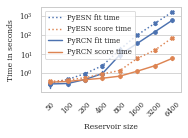

In [19]:
fig, axs = plt.subplots()
fig.set_size_inches(4/1.6, 2.5/1.6)
sns.pointplot(data=df, x="param_esn__regressor__hidden_layer_size", y="mean_fit_time", hue="Architecture", linestyles=[":", ":"], markers="X", ci="sd", ax=axs)
sns.pointplot(data=df, x="param_esn__regressor__hidden_layer_size", y="mean_score_time", hue="Architecture", ci="sd", ax=axs)
axs.legend(handles=axs.lines[::8+1], labels=["PyESN fit time", "PyESN score time", "PyRCN fit time", "PyRCN score time"],
           loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=1)
axs.set_yscale('log')
axs.set(xlabel="Reservoir size", ylabel="Time in seconds")
plt.xticks(rotation=45)
plt.savefig('ESN_Benchmark.pdf', bbox_inches='tight', pad_inches=0)

In [20]:
search1 = load(f"results/skelm_har_seq_elm_h{H}.joblib")
df1 = pd.DataFrame(search1.cv_results_).rename(
    columns={"param_elm__regressor__n_neurons": "param_elm__regressor__hidden_layer_size"})
df1["Architecture"] = "HP-ELM"

search2 = load(f"results/pyrcn_har_seq_elm_h{H}.joblib")
df2 = pd.DataFrame(search2.cv_results_)
df2["Architecture"] = "PyRCN"
df = pd.concat([df1, df2]).reset_index(drop=True)

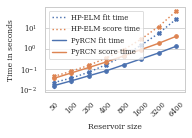

In [21]:
fig, axs = plt.subplots()
fig.set_size_inches(4/1.6, 2.5/1.6)
sns.pointplot(data=df, x="param_elm__regressor__hidden_layer_size", y="mean_fit_time", hue="Architecture", linestyles=[":", ":"], markers="X", ci="sd", ax=axs)
sns.pointplot(data=df, x="param_elm__regressor__hidden_layer_size", y="mean_score_time", hue="Architecture", ci="sd", ax=axs)
axs.legend(handles=axs.lines[::8+1], labels=["HP-ELM fit time", "HP-ELM score time", "PyRCN fit time", "PyRCN score time"],
           loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=1)
axs.set_yscale('log')
axs.set(xlabel="Reservoir size", ylabel="Time in seconds")
plt.xticks(rotation=45)
plt.savefig('ELM_Benchmark.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
df1 = df1.sort_values(by="param_elm__regressor__hidden_layer_size").reset_index(drop=True)
df2 = df2.sort_values(by="param_elm__regressor__hidden_layer_size").reset_index(drop=True)
df1["fit_speedup"] = df1["mean_fit_time"] / df2["mean_fit_time"]
df1["score_speedup"] = df1["mean_score_time"] / df2["mean_score_time"]

In [15]:
print(df1["params"][-1:], df2["params"][-1:])

199    {'elm__regressor__alpha': 1.5787174064955395e-...
Name: params, dtype: object 199    {'elm__regressor__alpha': 1.5787174064955395e-...
Name: params, dtype: object


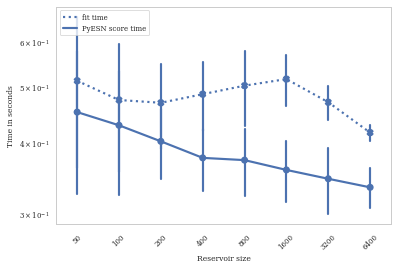

In [16]:
fig, axs = plt.subplots()
# fig.set_size_inches(4/1.6, 2.5/1.6)
sns.pointplot(data=df1, x="param_elm__regressor__hidden_layer_size", y="fit_speedup", linestyles=":", markers="X", ci="sd", ax=axs)
sns.pointplot(data=df1, x="param_elm__regressor__hidden_layer_size", y="score_speedup", ci="sd", ax=axs)
axs.legend(handles=axs.lines[::8+1], labels=["fit time", "PyESN score time", "PyRCN fit time", "PyRCN score time"],
           loc='upper left', bbox_to_anchor=(0.0, 1.0), ncol=1)
axs.set_yscale('log')
axs.set(xlabel="Reservoir size", ylabel="Time in seconds")
plt.xticks(rotation=45)
plt.savefig('ESN_speedup.pdf', bbox_inches='tight', pad_inches=0)

In [161]:
import numpy as np
np.mean(df1["fit_speedup"][:31])

0.5134016693430727

In [21]:
df1[["param_elm__regressor__hidden_layer_size", "mean_fit_time", "mean_score_time"]][-31:]

,param_elm__regressor__hidden_layer_size,mean_fit_time,mean_score_time
169,6400,27.836341,1.135544
170,6400,25.799664,1.302225
171,6400,24.992285,1.182418
172,6400,26.060122,1.364738
173,6400,27.664449,1.067822
174,6400,26.086153,1.395982
175,6400,26.200753,1.333474
176,6400,26.153872,1.395979
177,6400,25.924676,1.281392
178,6400,26.622670,1.468911


In [22]:
df2[["param_elm__regressor__hidden_layer_size", "mean_fit_time", "mean_score_time"]][-31:]

,param_elm__regressor__hidden_layer_size,mean_fit_time,mean_score_time
169,6400,62.361584,3.904560
170,6400,60.853471,3.737302
171,6400,59.525176,4.204506
172,6400,60.242684,4.232453
173,6400,62.051021,3.524729
174,6400,61.047968,4.337884
175,6400,60.526676,4.129832
176,6400,61.119885,3.968040
177,6400,64.492890,3.885089
178,6400,66.525541,4.274756
